# Notebook 1/6 Data Extraction and Preprocessing  

This notebook describes the full preprocessing pipeline applied to the raw sensor data
before training the machine learning models.

We focus on:
- signal cleaning and smoothing
- feature engineering
- preparation of the final training dataset


## Task 1: Data Ingestion - Load all time-series (HF, pressure) and static data.

In [1]:
from utils.Data_extraction_utils import *

In [ ]:
# Define data directories :
chair_hf_dir = os.path.dirname("ChairHeatFluxData/Processed_Heat_Flux/")
pressure_dir = os.path.dirname("ChairPressureData/")
human_hf_dir = os.path.dirname("HumanHeatFluxData/")

# Who are the test participants? :
test_ids = ["A17", "B11", "K18", "A23"] #ID correspond to the ones chosen in the notebook 2/6: validation_subjectwise.ipynb

### 1.A - Extracting the pressure chair-sensors data

In [3]:
# Pressure data directories
female_dir = os.path.join(pressure_dir, "Female_Processed data")
male_dir   = os.path.join(pressure_dir, "Male_Processed data")

# Load female + male datasets
female_train, female_test = load_pressure_folder(female_dir, "F", test_ids)
male_train,   male_test   = load_pressure_folder(male_dir,   "M", test_ids)

# Concatenate the male and female groups
train_data = pd.concat(female_train + male_train, ignore_index=True)
test_data  = pd.concat(female_test  + male_test,  ignore_index=True)

# Final sorting
sort_cols = [c for c in ["participant_id", "day", "Time"] if c in train_data.columns]
pressure_train = train_data.sort_values(sort_cols).reset_index(drop=True)
pressure_test  = test_data.sort_values(sort_cols).reset_index(drop=True)

# Drop Sensor 8 due to faulty readings
pressure_train.drop(columns=["Sensor 8"], inplace=True)
pressure_test.drop(columns=["Sensor 8"], inplace=True)

print("Train dataset shape:", pressure_train.shape)
print("Test dataset shape :", pressure_test.shape)

ChairPressureData/Female_Processed data : 26 files found
ChairPressureData/Male_Processed data : 26 files found
Train dataset shape: (1010418, 27)
Test dataset shape : (190725, 27)


In [4]:
print('Number of participants pressure data (training):', pressure_train['participant_id'].value_counts().size)
print('Number of participants pressure data (testing):', pressure_test['participant_id'].value_counts().size)
print('Number of days:', pressure_train['day'].value_counts().size)
print()

print('Data size per number of rows (training):', pressure_train.shape[0])
print('Data size per id (training):', pressure_train.groupby('participant_id').size())
print()

print('Data_size per number of rows (testing):', pressure_test.shape[0])
print('Data size per id (testing):', pressure_test.groupby('participant_id').size())

Number of participants pressure data (training): 20
Number of participants pressure data (testing): 4
Number of days: 2

Data size per number of rows (training): 1010418
Data size per id (training): participant_id
A11    49234
C12    44842
D13    62547
E12    40176
E18    44377
F14    45520
H16    64807
I13    50569
I19    44209
J17    46356
L19    55889
M20    46994
N21    39232
O14    51333
O20    53823
P22    55588
Q23    44884
U15    64611
Y16    60461
Y22    44966
dtype: int64

Data_size per number of rows (testing): 190725
Data size per id (testing): participant_id
A17    50416
A23    44827
B11    42072
K18    53410
dtype: int64


### 1.B - Extracting the human heat flux data (ground truth)

In [5]:
# Load ground truth human heat flux data
gt_heat_train, gt_heat_test = load_heat_flux_data(human_hf_dir, test_ids)

[WARN] HumanHeatFluxData/CALERA_27012023_D13-1: expected 2 CSVs, found 1 -> skipped


In [6]:
print('Number of participants (training)/ Heat:', gt_heat_train['participant_id'].value_counts().size)
print('Number of participants (testing)/ Heat:', gt_heat_test['participant_id'].value_counts().size)
print('Number of days:', gt_heat_train['day'].value_counts().size)
print()

print('Data size (training):', gt_heat_train.shape[0])
print()

print('Data size (testing):', gt_heat_test.shape[0])

Number of participants (training)/ Heat: 20
Number of participants (testing)/ Heat: 4
Number of days: 2

Data size (training): 1116840

Data size (testing): 227390


### 1.C - Merging the pressure and human heat flux dataframes

In [7]:
# Convert "Time" columns to datetime
print('Time before conversion:', pressure_train["Time"].dtype, pressure_test["Time"].dtype)
pressure_train["Time"] = pd.to_datetime(pressure_train["Time"])
pressure_test["Time"]  = pd.to_datetime(pressure_test["Time"])
print('Time after conversion :', pressure_train["Time"].dtype, pressure_test["Time"].dtype)
print()

gt_heat_train["Time"] = pd.to_datetime(gt_heat_train["Time"])
gt_heat_test["Time"]  = pd.to_datetime(gt_heat_test["Time"])

# Merge heat flux and pressure data by group
train_gtruth_press_merged = merge_heat_pressure_by_group(pressure_train, gt_heat_train, tolerance_seconds=2)
test_gtruth_press_merged  = merge_heat_pressure_by_group(pressure_test,  gt_heat_test,  tolerance_seconds=2)

# Final shapes
print("Train merged shape:", train_gtruth_press_merged.shape)
print("Test merged shape :", test_gtruth_press_merged.shape)

Time before conversion: object object
Time after conversion : datetime64[ns] datetime64[ns]

Train merged shape: (1116840, 29)
Test merged shape : (227390, 29)


In [8]:
# We change the Ids to match the chairs heat flux csv IDs
train_gtruth_press_merged = apply_id_mapping(train_gtruth_press_merged)
test_gtruth_press_merged  = apply_id_mapping(test_gtruth_press_merged)

### 1.D - Extracting the heat flux chair-sensors data

In [9]:
# Load chair heat flux data
chair_hf_train, chair_hf_test = load_chair_heatflux(chair_hf_dir, test_ids)

print(chair_hf_train["participant_id"].unique())
print(chair_hf_test["participant_id"].unique())

[WARN] ChairHeatFluxData/Processed_Heat_Flux/F_10_1: unexpected sensor set {4, 6} (missing 7 or 8) -> skipped
[WARN] ChairHeatFluxData/Processed_Heat_Flux/F_10_2: unexpected sensor set {4, 6} (missing 7 or 8) -> skipped
[INFO] ChairHeatFluxData/Processed_Heat_Flux/F_12_2: only seat sensors {11, 4, 6} (no 7/8) -> skipped
[INFO] ChairHeatFluxData/Processed_Heat_Flux/F_2_1: only seat sensors {11, 4, 6} (no 7/8) -> skipped
[INFO] ChairHeatFluxData/Processed_Heat_Flux/F_4_1: only seat sensors {11, 4, 6} (no 7/8) -> skipped
[INFO] ChairHeatFluxData/Processed_Heat_Flux/F_4_2: only seat sensors {11, 4, 6} (no 7/8) -> skipped
[INFO] ChairHeatFluxData/Processed_Heat_Flux/F_9_1: only seat sensors {11, 4, 6} (no 7/8) -> skipped
[INFO] ChairHeatFluxData/Processed_Heat_Flux/F_9_2: only seat sensors {11, 4, 6} (no 7/8) -> skipped
[INFO] ChairHeatFluxData/Processed_Heat_Flux/M_10_1: only seat sensors {11, 4, 6} (no 7/8) -> skipped
[INFO] ChairHeatFluxData/Processed_Heat_Flux/M_10_2: only seat sensors 

### 1.E - Merging all dataframes


In [10]:
# Convert "Time" columns to datetime
for df in [train_gtruth_press_merged, test_gtruth_press_merged, chair_hf_train, chair_hf_test]:
    df["Time"] = pd.to_datetime(df["Time"])

# Merge chair heat flux with human pressure + heat flux data
df_train_merge = merge_chair_with_human_pressure(chair_hf_train, train_gtruth_press_merged, tolerance_seconds=2)
df_test_merge  = merge_chair_with_human_pressure(chair_hf_test,  test_gtruth_press_merged,  tolerance_seconds=2)



print("Full train shape:", df_train_merge.shape)
print("Full test shape :", df_test_merge.shape)
print()

print("IDs train:", df_train_merge["participant_id"].unique())
print("IDs test :", df_test_merge["participant_id"].unique())

Full train shape: (840098, 31)
Full test shape : (251017, 31)

IDs train: ['F1' 'F11' 'F2' 'F3' 'F5' 'F6' 'F8' 'M11' 'M12' 'M2' 'M3' 'M5' 'M6' 'M8']
IDs test : ['F12' 'F7' 'M1' 'M7']


## Task 2: Cleaning and Imputation

### 2.A - Choosing only the times when the experiment was on 

In [11]:
activity_path = os.path.join(pressure_dir, "Actual timing of activities per person.xlsx")

activity_intervals = load_activity_intervals(activity_path)

df_train_merge["Time"] = pd.to_datetime(df_train_merge["Time"])
df_test_merge["Time"]  = pd.to_datetime(df_test_merge["Time"])

df_train_active = filter_to_active_periods(df_train_merge, activity_intervals)
df_test_active = filter_to_active_periods(df_test_merge,  activity_intervals)

print("Number of rows removed in train :", df_train_merge.shape[0] - df_train_active.shape[0])
print("Number of rows removed in test  :", df_test_merge.shape[0]  - df_test_active.shape[0])
print()

print("Full train :", df_train_merge.shape, "->", df_train_active.shape)
print("Full test  :", df_test_merge.shape,  "->", df_test_active.shape)
print() 

print("IDs train actifs:", df_train_active["participant_id"].unique())
print("IDs test actifs :", df_test_active["participant_id"].unique())

Number of rows removed in train : 0
Number of rows removed in test  : 0

Full train : (840098, 31) -> (840098, 32)
Full test  : (251017, 31) -> (251017, 32)

IDs train actifs: ['F1' 'F11' 'F2' 'F3' 'F5' 'F6' 'F8' 'M11' 'M12' 'M2' 'M3' 'M5' 'M6' 'M8']
IDs test actifs : ['F12' 'F7' 'M1' 'M7']


In [12]:
print(df_train_active.columns)

Index(['participant_id', 'day', 'Time', 'chair_back_flux', 'chair_thigh_flux',
       'back_flux', 'thigh_flux', 'Sensor 0', 'Sensor 1', 'Sensor 2',
       'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6', 'Sensor 7', 'Sensor 9',
       'Sensor 10', 'Sensor 11', 'Sensor 12', 'SD', 'Mean', 'CV', 'CVm',
       'CVmdif', 'SD_B', 'Mean_B', 'CV_B', 'CVm_B', 'CVmdif_B', 'room_temp_C',
       'Cvmdif', 'Session'],
      dtype='object')


### 2.B - Eliminate the NaN values and remove unnecessary columns

In [13]:
nan_percent = df_train_active.isna().mean() * 100
print(nan_percent)

participant_id       0.000000
day                  0.000000
Time                 0.000000
chair_back_flux      0.000000
chair_thigh_flux     3.289973
back_flux           35.567160
thigh_flux          35.567160
Sensor 0            35.820821
Sensor 1            35.820821
Sensor 2            35.820821
Sensor 3            35.820821
Sensor 4            35.820821
Sensor 5            35.820821
Sensor 6            35.820821
Sensor 7            35.820821
Sensor 9            35.820821
Sensor 10           35.820821
Sensor 11           35.820821
Sensor 12           35.820821
SD                  35.820821
Mean                35.820821
CV                  35.820821
CVm                 35.820821
CVmdif              66.850177
SD_B                66.850177
Mean_B              66.850177
CV_B                66.850177
CVm_B               66.850177
CVmdif_B            66.850177
room_temp_C         35.820821
Cvmdif              68.972191
Session              0.000000
dtype: float64


In [14]:
cols_to_drop = ["SD", "Mean", "CV", "CVm", "CVmdif", "SD_B", "Mean_B", "CV_B", "CVm_B", "CVmdif_B", "Cvmdif"]

df_train_filtered = df_train_active.dropna(subset=["Sensor 0"]).drop(cols_to_drop, axis=1)
df_test_filtered = df_test_active.dropna(subset=["Sensor 0", "chair_thigh_flux"]).drop(cols_to_drop, axis=1)

nan_percent = df_train_filtered.isna().mean() * 100
print(nan_percent)

participant_id      0.000000
day                 0.000000
Time                0.000000
chair_back_flux     0.000000
chair_thigh_flux    2.727907
back_flux           0.000000
thigh_flux          0.000000
Sensor 0            0.000000
Sensor 1            0.000000
Sensor 2            0.000000
Sensor 3            0.000000
Sensor 4            0.000000
Sensor 5            0.000000
Sensor 6            0.000000
Sensor 7            0.000000
Sensor 9            0.000000
Sensor 10           0.000000
Sensor 11           0.000000
Sensor 12           0.000000
room_temp_C         0.000000
Session             0.000000
dtype: float64


In [15]:
df_train_filtered = df_train_filtered.replace([np.inf, -np.inf], np.nan)
df_train_filtered = df_train_filtered.dropna()

df_test_filtered = df_test_filtered.replace([np.inf, -np.inf], np.nan)
df_test_filtered = df_test_filtered.dropna()

df_train_filtered.isna().sum()

participant_id      0
day                 0
Time                0
chair_back_flux     0
chair_thigh_flux    0
back_flux           0
thigh_flux          0
Sensor 0            0
Sensor 1            0
Sensor 2            0
Sensor 3            0
Sensor 4            0
Sensor 5            0
Sensor 6            0
Sensor 7            0
Sensor 9            0
Sensor 10           0
Sensor 11           0
Sensor 12           0
room_temp_C         0
Session             0
dtype: int64

In [16]:
print(df_train_filtered.columns)

Index(['participant_id', 'day', 'Time', 'chair_back_flux', 'chair_thigh_flux',
       'back_flux', 'thigh_flux', 'Sensor 0', 'Sensor 1', 'Sensor 2',
       'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6', 'Sensor 7', 'Sensor 9',
       'Sensor 10', 'Sensor 11', 'Sensor 12', 'room_temp_C', 'Session'],
      dtype='object')


## Task 3: Data Smoothing using the Savitzky–Golay filter

The raw pressure and heatflux sensor data is highly noisy, which makes it difficult to visualize patterns and extract meaningful features for machine learning. To address this, we apply **signal smoothing** directly on each sensor time series.

#### Why Savitzky–Golay?
The Savitzky–Golay (SG) filter is a widely used method for smoothing physiological and sensor signals because it:
- reduces high-frequency noise,
- preserves the overall shape of the signal,
- keeps sharp transitions better than a moving average,
- does not introduce significant phase shift.

Unlike simple moving averages, SG smoothing fits a **local polynomial** to the data within a sliding window, allowing noise reduction without destroying important structure.

For each signal we:
1. compute a temporary `signal_sg`,  
2. overwrite the raw column with this smoothed version,  
3. remove all helper `_sg` columns.

### Parameters
We use:

window length = 101
polynomial order = 2

This configuration provides strong noise reduction while preserving the dynamics of the physiological signals.

### Output
Two final smoothed datasets are produced:
- `Full_train_data_smooth.csv`
- `Full_test_data_smooth.csv`

These contain the same columns as the raw data, except that all sensor features now hold **Savitzky–Golay–smoothed values**.


We then visualize the results both over specific zoomed time windows to inspect how well the smoothing performs.


In [17]:
# Pressure sensors
pressure_train = [c for c in df_train_filtered.columns if c.startswith("Sensor")]
pressure_test  = [c for c in df_test_filtered.columns  if c.startswith("Sensor")]

# Heat-flux related features
flux_candidates = ["chair_back_flux", "chair_thigh_flux", "back_flux", "thigh_flux"]
flux_train = [c for c in flux_candidates if c in df_train_filtered.columns]
flux_test  = [c for c in flux_candidates if c in df_test_filtered.columns]

cols_to_smooth_train = pressure_train + flux_train
cols_to_smooth_test  = pressure_test  + flux_test

print("Columns smoothed (train):", cols_to_smooth_train)
print("Columns smoothed (test) :", cols_to_smooth_test)
print()

# Grouping by participant + day if available
group_cols = [c for c in ["participant_id", "day"] if c in df_train_filtered.columns]

# Build smoothed copies of train and test
df_train_smooth = make_smoothed_copy(
    df_train_filtered,
    signal_cols=cols_to_smooth_train,
    sg_window=101,
    sg_poly=2,
    group_cols=group_cols,
)

df_test_smooth = make_smoothed_copy(
    df_test_filtered,
    signal_cols=cols_to_smooth_test,
    sg_window=101,
    sg_poly=2,
    group_cols=group_cols,
)

print("Train shape (original → smooth):", df_train_filtered.shape, "→", df_train_smooth.shape)
print("Test  shape (original → smooth):", df_test_filtered.shape,  "→", df_test_smooth.shape)

Columns smoothed (train): ['Sensor 0', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6', 'Sensor 7', 'Sensor 9', 'Sensor 10', 'Sensor 11', 'Sensor 12', 'chair_back_flux', 'chair_thigh_flux', 'back_flux', 'thigh_flux']
Columns smoothed (test) : ['Sensor 0', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6', 'Sensor 7', 'Sensor 9', 'Sensor 10', 'Sensor 11', 'Sensor 12', 'chair_back_flux', 'chair_thigh_flux', 'back_flux', 'thigh_flux']

Train shape (original → smooth): (524459, 21) → (524459, 21)
Test  shape (original → smooth): (170156, 21) → (170156, 21)


Signals to plot: ['Sensor 0', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6', 'Sensor 7', 'Sensor 9', 'Sensor 10', 'Sensor 11', 'Sensor 12', 'chair_back_flux', 'chair_thigh_flux', 'back_flux', 'thigh_flux']
Raw samples: 3601, Smoothed samples: 3601


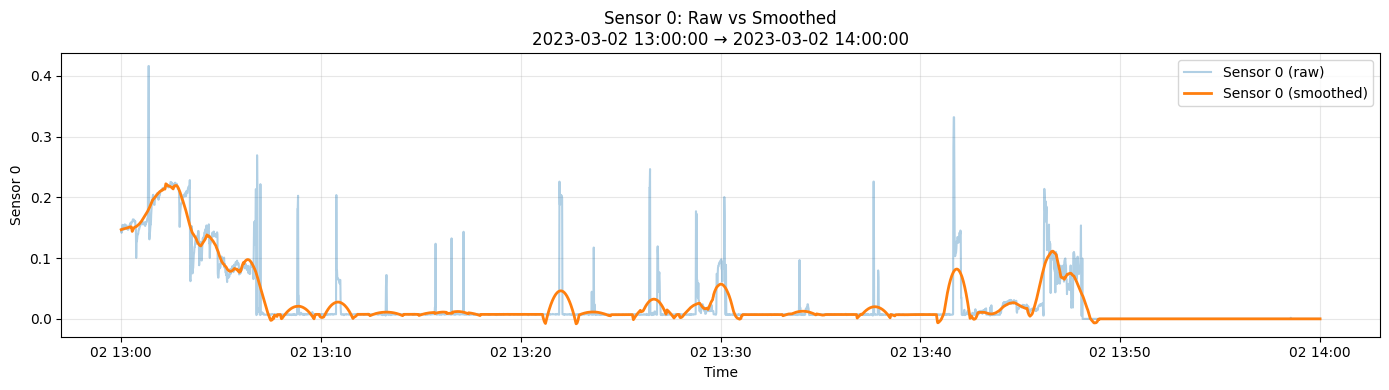

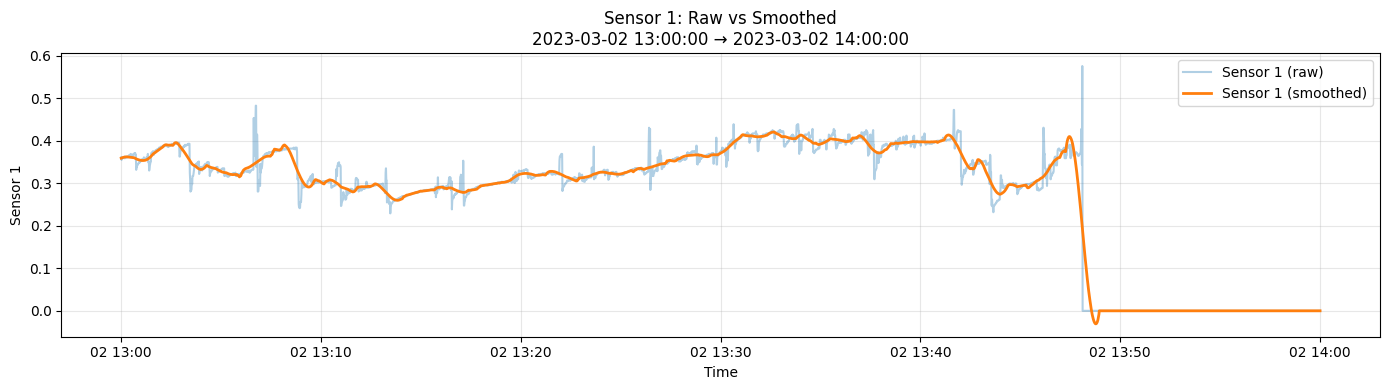

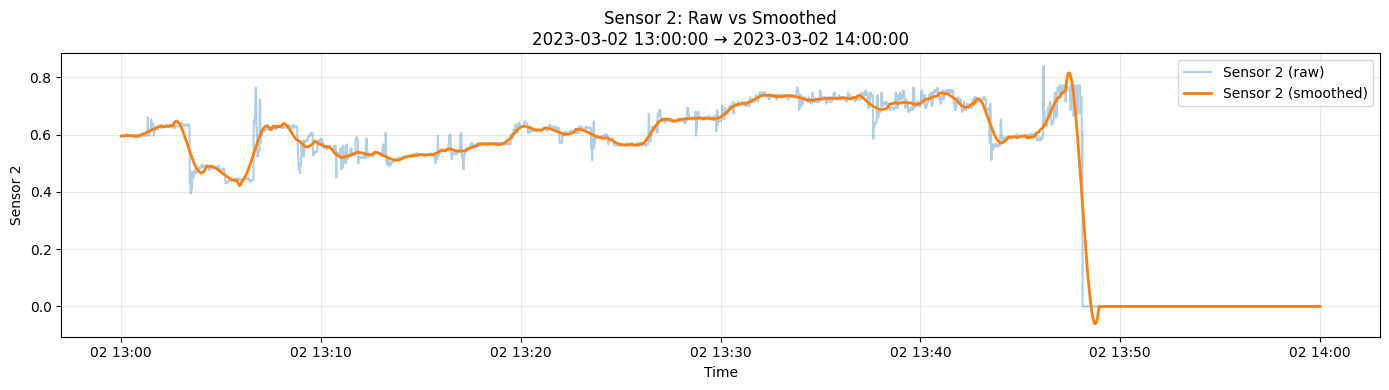

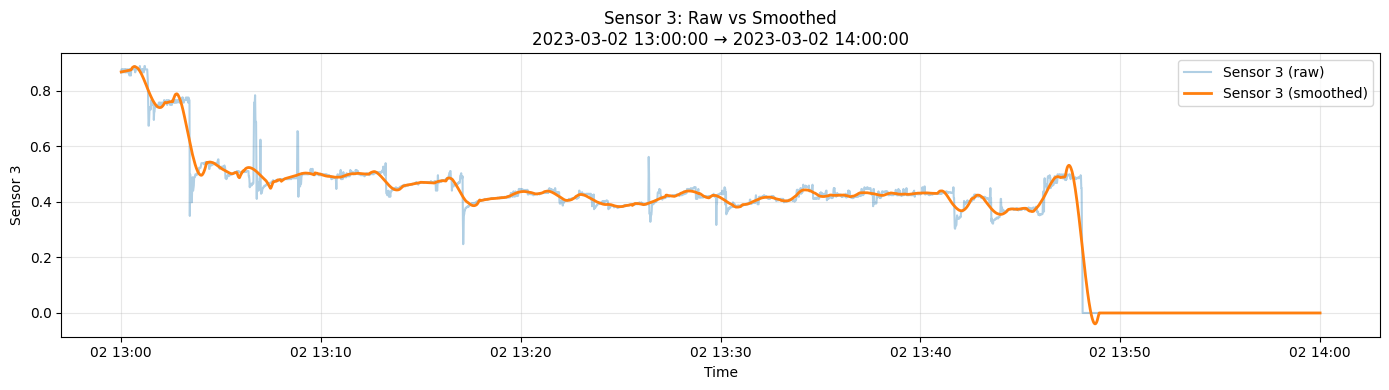

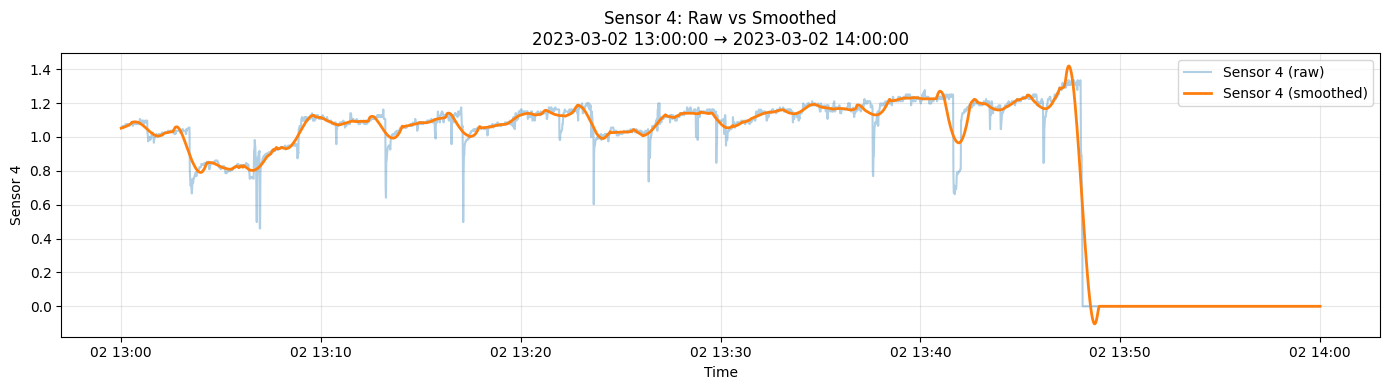

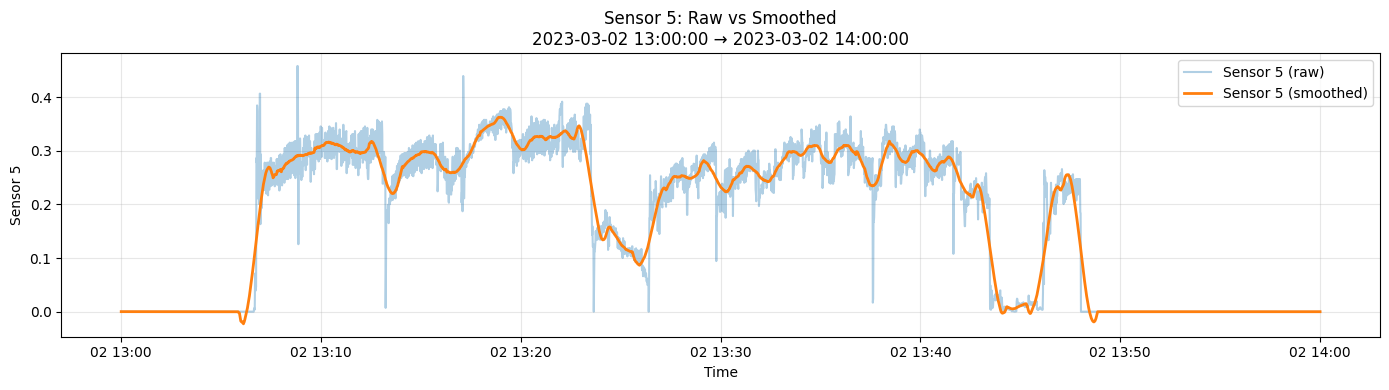

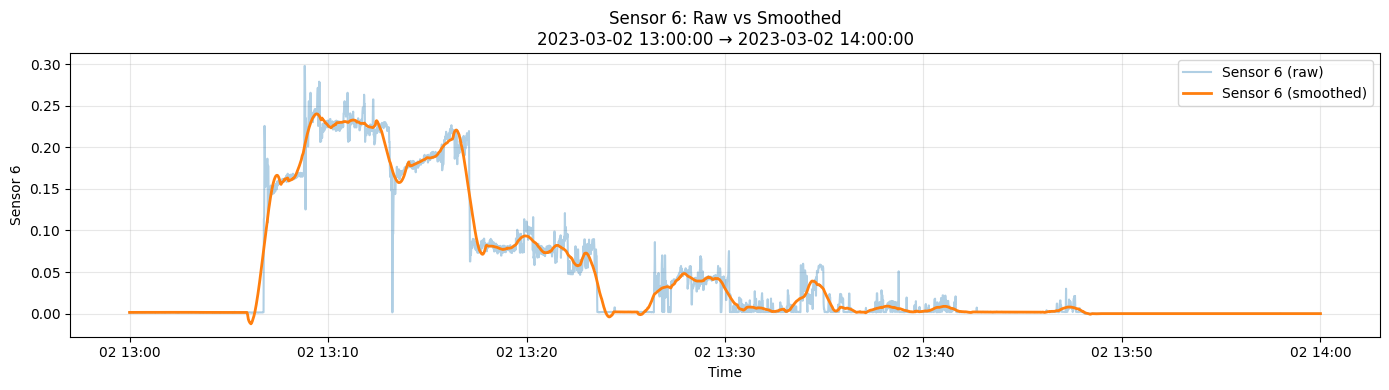

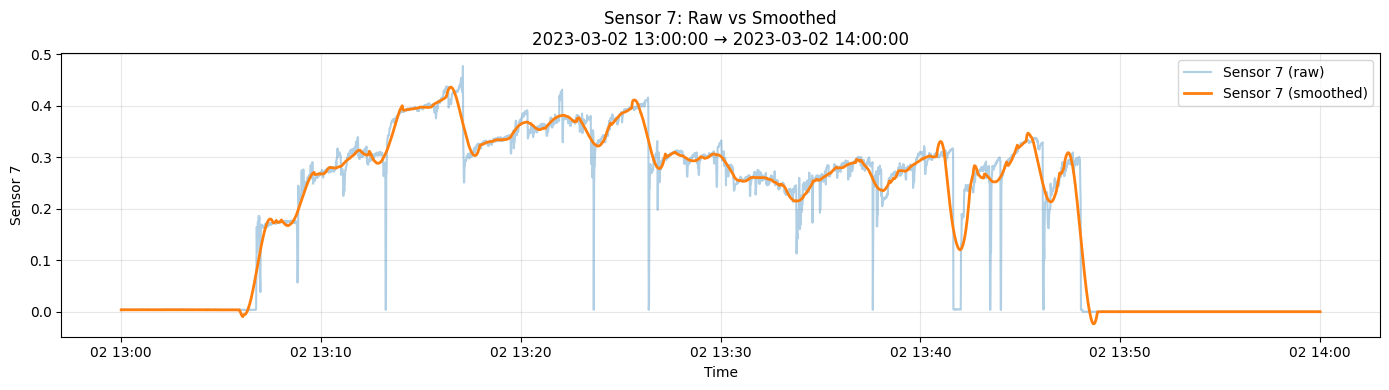

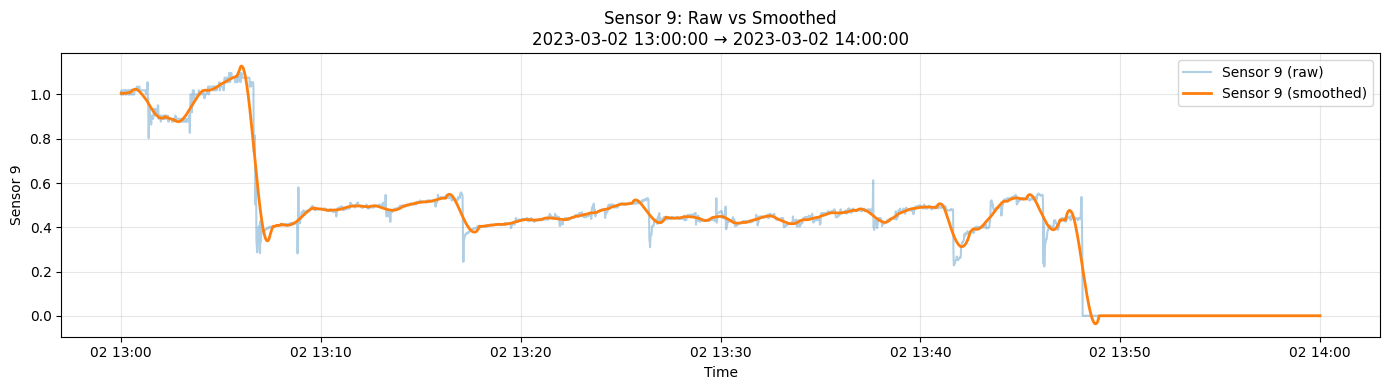

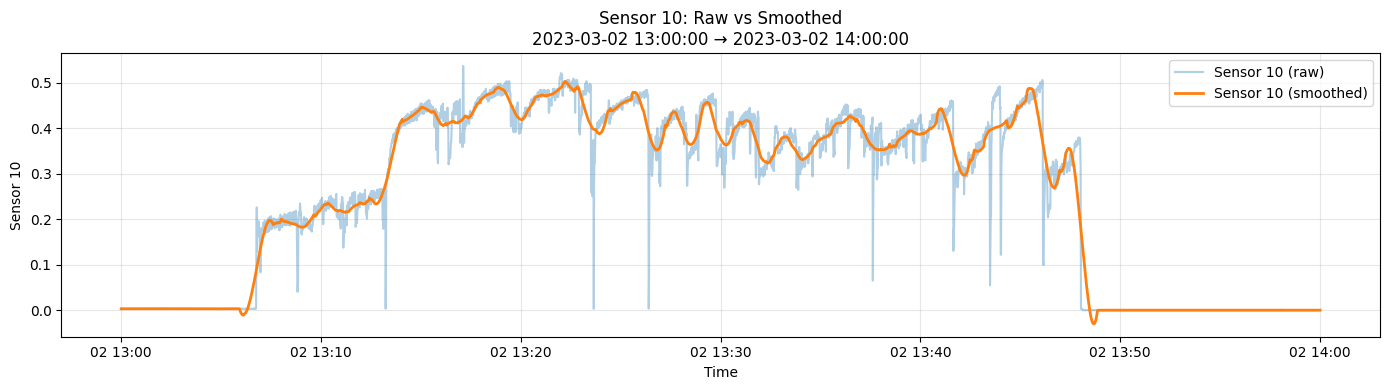

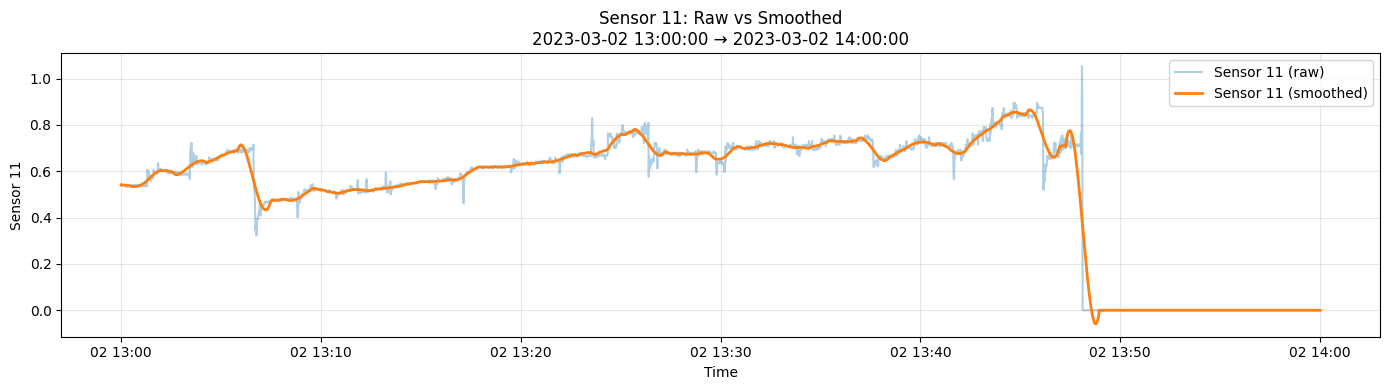

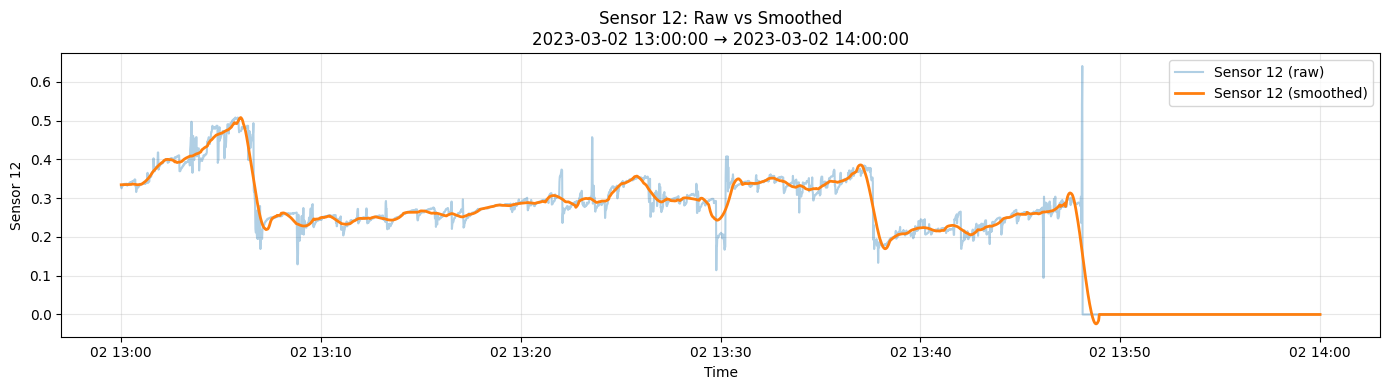

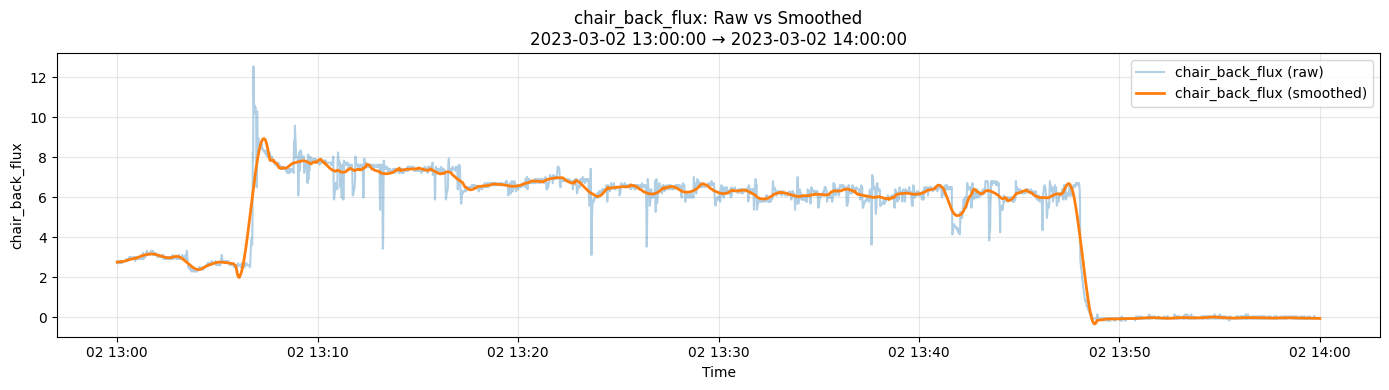

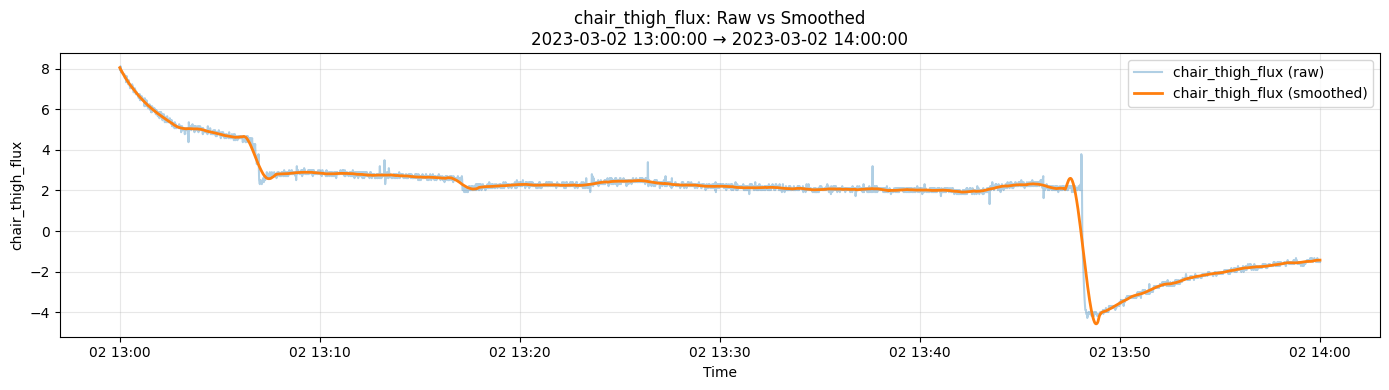

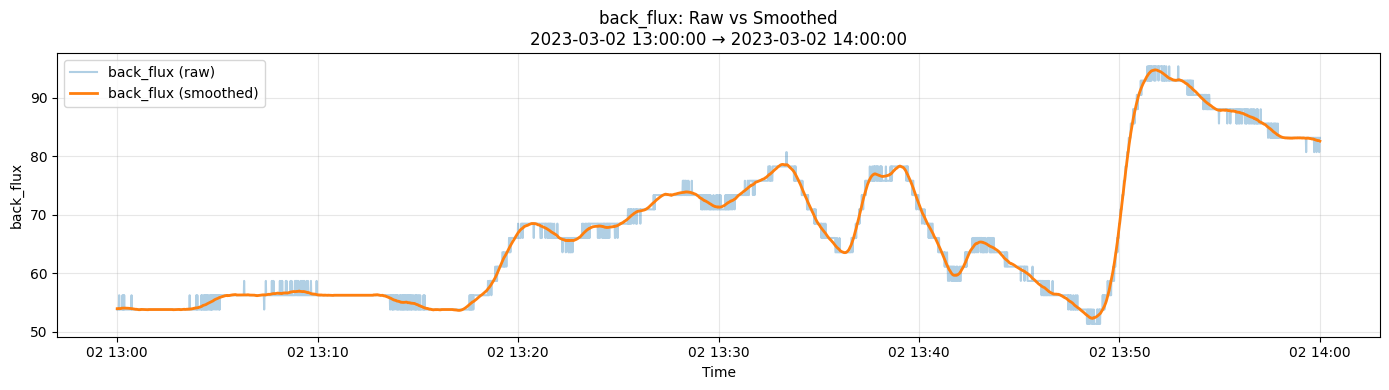

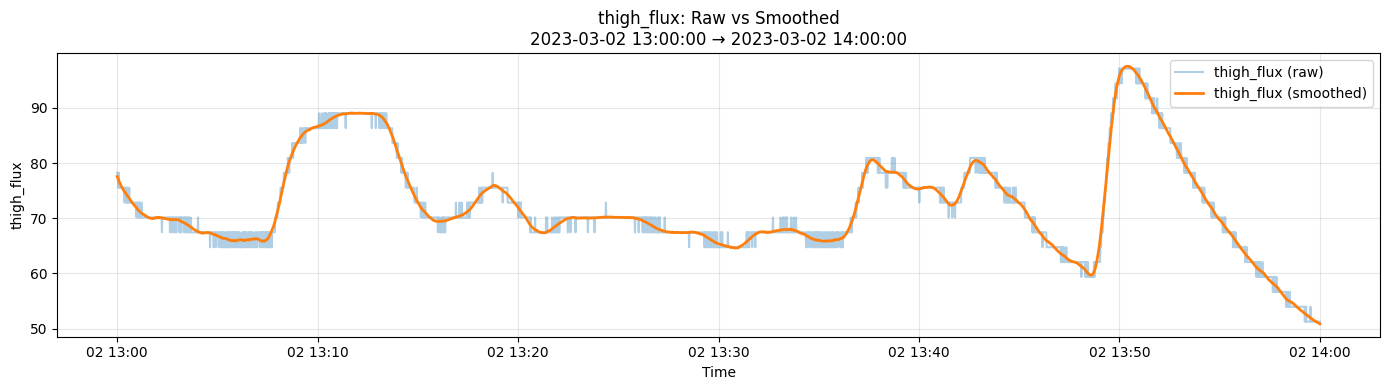

In [18]:
# Ensure Time is datetime
df_train_filtered["Time"] = pd.to_datetime(df_train_filtered["Time"])
df_train_smooth["Time"]   = pd.to_datetime(df_train_smooth["Time"])

# Select time window
start_time = pd.to_datetime("2023-03-02 13:00:00")
end_time   = pd.to_datetime("2023-03-02 14:00:00")

# Identify signals
pressure_cols = [c for c in df_train_filtered.columns if c.startswith("Sensor")]

flux_candidates = ["chair_back_flux", "chair_thigh_flux", "back_flux", "thigh_flux"]
flux_cols = [c for c in flux_candidates if c in df_train_filtered.columns]

signal_cols = pressure_cols + flux_cols

print("Signals to plot:", signal_cols)

# Call plotting function
plot_raw_vs_smoothed(
    raw_df=df_train_filtered,
    smooth_df=df_train_smooth,
    time_col="Time",
    signal_cols=signal_cols,
    start_time=start_time,
    end_time=end_time
)

In [19]:
save_cleaned_datasets(df_train_smooth, df_test_smooth, "without_FE")

Saved:
 - Cleaned_Datasets/Train_without_FE.csv
 - Cleaned_Datasets/Test_without_FE.csv


## Task 4: Feature engineering

### 4.A – Handling lag and rolling-window features to build clean feature matrices for the baseline models

Lag and rolling-window features (historical context) are essential to exploit the temporal structure of the smoothed sensor data. However, these transformations naturally introduce `NaN` values at the beginning of each session (e.g. for the first lagged points or for the first rolling windows).

In this step, we define helper functions to **impute time-series features within each session**:

- for `*_lag` features, we replace missing values by the **first valid value** of the session;
- for `*_roll_mean` features, we use the **mean of past values** (or the first valid value if no history exists yet);
- for `*_roll_std` features, we use the **standard deviation of past values** (or `0` at the very beginning of the session).

The function `impute_time_features` applies these rules **session-wise** (grouped by `Session`) so that no information leaks across different recordings.

We then apply the time-series imputation strategy to both the training and test feature matrices:

1. `impute_time_features(X_train)` and `impute_time_features(X_test)`  
   ensure that all lag and rolling-window features are **fully defined** within each session.

2. We then drop the `Session` column from `X_train` and `X_test`,  
   as it is only used for grouping and should not be used as a model input.

This yields clean, temporally consistent feature matrices that are ready to be used for the baseline regression models.


In [20]:
historical_features = ['chair_back_flux', 'chair_thigh_flux', 'Sensor 0', 'Sensor 1', 'Sensor 2', 'Sensor 3',
                'Sensor 4', 'Sensor 5', 'Sensor 6', 'Sensor 7',
                'Sensor 9', 'Sensor 10', 'Sensor 11', 'Sensor 12']
lags = [1, 3, 5, 10, 30, 60]
windows = [3, 5, 10, 30]

new_cols_train = {}
new_cols_test = {}

for col in historical_features:
    for lag in lags:
        new_cols_train[f"{col}_lag{lag}"] = df_train_smooth.groupby("Session")[col].shift(lag)
        new_cols_test[f"{col}_lag{lag}"]  = df_test_smooth.groupby("Session")[col].shift(lag)

    for w in windows:
        g_train = df_train_smooth.groupby("Session")[col]
        g_test  = df_test_smooth.groupby("Session")[col]

        new_cols_train[f"{col}_roll{w}_mean"] = g_train.rolling(w).mean().reset_index(level=0, drop=True)
        new_cols_train[f"{col}_roll{w}_std"]  = g_train.rolling(w).std().reset_index(level=0, drop=True)
        new_cols_test[f"{col}_roll{w}_mean"]  = g_test.rolling(w).mean().reset_index(level=0, drop=True)
        new_cols_test[f"{col}_roll{w}_std"]   = g_test.rolling(w).std().reset_index(level=0, drop=True)

# Une seule opération de concaténation
df_train_hist = pd.concat([df_train_smooth, pd.DataFrame(new_cols_train, index=df_train_smooth.index)], axis=1)
df_test_hist  = pd.concat([df_test_smooth,  pd.DataFrame(new_cols_test,  index=df_test_smooth.index)],  axis=1)

In [21]:
df_train_final = impute_historical_features(df_train_hist)
df_test_final  = impute_historical_features(df_test_hist)

In [22]:
# Save to new CSV files
save_cleaned_datasets(df_train_final, df_test_final, "final")

Saved:
 - Cleaned_Datasets/Train_final.csv
 - Cleaned_Datasets/Test_final.csv


Data normalization is not handled in this file, because whether normalization is appropriate depends on the specific model used during training. For example, normalization is useful for models like Linear Regression, but not recommended for tree-based models such as Random Forest.